In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.feature_selection import RFECV, SequentialFeatureSelector
import sys
sys.path.append('../')

from TS_model.feature_engeneering import FeatureEngineer
from TS_model.feature_selection import TransferEntropyFeatureSelection, WrapperMethod

%load_ext autoreload
%autoreload 2

# Выгрузка изначальных данных & Feature engeneering

In [2]:
data = pd.read_excel('../Project 2_2023.xlsx', parse_dates=True, index_col=0)
data.columns = data.columns.str.lower()
data['date'] = pd.to_datetime(data['date'])
data.head()

,date,income,outcome,balance
0,2017-01-09,1.343028,1.487865,-0.144836
1,2017-01-10,1.068610,1.194182,-0.125572
2,2017-01-11,0.944429,0.936663,0.007767
3,2017-01-12,1.672202,0.875379,0.796823
4,2017-01-13,0.955924,0.975645,-0.019721


In [3]:
feature_extactor = FeatureEngineer(data)

In [4]:
feature_extactor.add_lag_features(lags=[1, 2, 3, 7, 30, 60])
feature_extactor.add_rolling_features(windows=[3, 7, 30])
feature_extactor.add_seasonal_features()
# feature_extactor.add_special_dates() ТУТ НАДО ПЕРЕДАТЬ ДАТЫ НАЛОГОВОГО КАЛЕНДАРЯ В ФОРМАТЕ КОТОРЫЙ ЗАШИТ В МЕТОДЕ ИЛИ ПОМЕНЯТЬ МЕТОД
# add_macro_features() ДАТАФРЕЙМ МАКРО ФИЧЕЙ
data_more = feature_extactor.get_feature_df()

In [5]:
data_all = data.copy().merge(data_more.copy().dropna(), on=['date'], how='inner').sort_values(by='date').drop(['date'], axis=1)
features = data_all.copy().drop(['balance', 'income', 'outcome'], axis=1)
target = data_all.copy()['balance']

# Feature selection

## Встроенные методы

In [6]:
tscv = TimeSeriesSplit(n_splits=5)

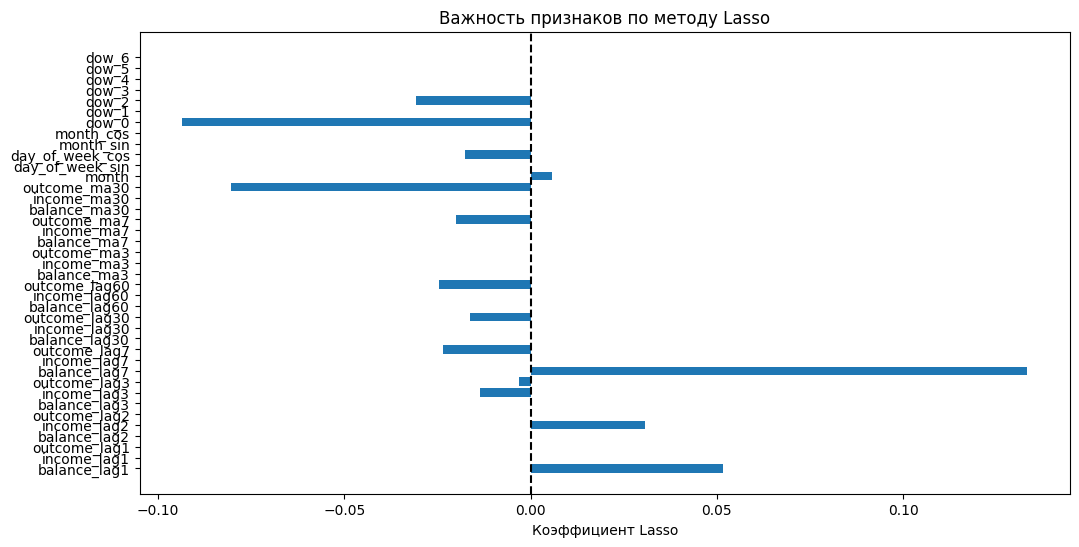

['balance_lag1',
 'income_lag2',
 'income_lag3',
 'outcome_lag3',
 'balance_lag7',
 'outcome_lag7',
 'outcome_lag30',
 'outcome_lag60',
 'outcome_ma7',
 'outcome_ma30',
 'month',
 'day_of_week_cos',
 'dow_0',
 'dow_2']

In [7]:
lasso = LassoCV(cv=tscv, max_iter=10000, random_state=42)
lasso.fit(features, target)

coefs = lasso.coef_
selected_features = features.columns[coefs != 0]

plt.figure(figsize=(12, 6))
plt.barh(features.columns, coefs)
plt.xlabel('Коэффициент Lasso')
plt.title('Важность признаков по методу Lasso')
plt.axvline(0, color='black', linestyle='--')
plt.show()

selected_features.tolist()

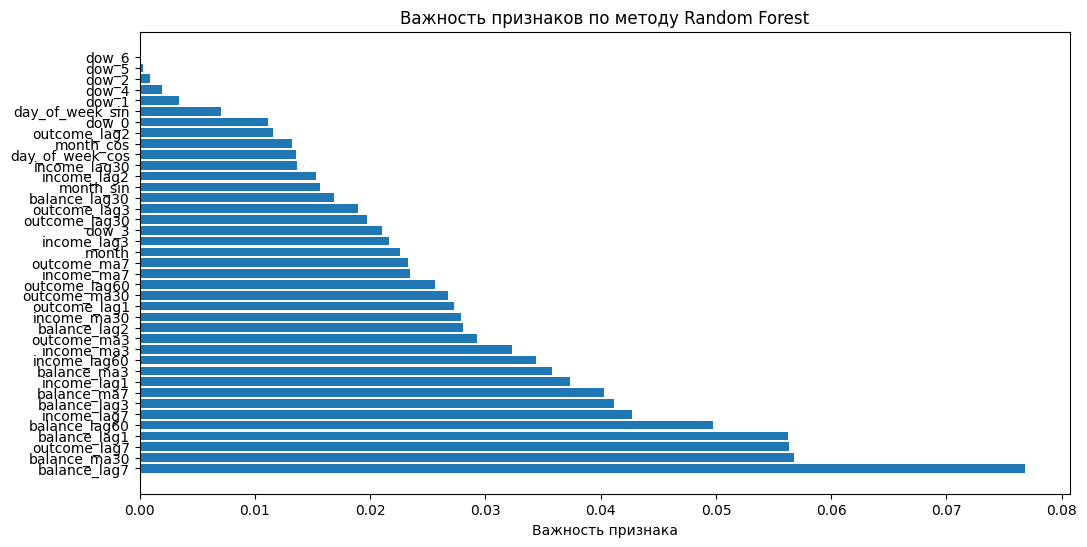

['balance_lag7',
 'balance_ma30',
 'outcome_lag7',
 'balance_lag1',
 'balance_lag60',
 'income_lag7',
 'balance_lag3',
 'balance_ma7',
 'income_lag1',
 'balance_ma3',
 'income_lag60',
 'income_ma3',
 'outcome_ma3',
 'balance_lag2',
 'income_ma30',
 'outcome_lag1',
 'outcome_ma30',
 'outcome_lag60',
 'income_ma7',
 'outcome_ma7',
 'month',
 'income_lag3',
 'dow_3',
 'outcome_lag30',
 'outcome_lag3',
 'balance_lag30',
 'month_sin',
 'income_lag2',
 'income_lag30',
 'day_of_week_cos',
 'month_cos',
 'outcome_lag2',
 'dow_0']

In [11]:
# Инициализация модели
model = RandomForestRegressor(n_estimators=500, random_state=42)

# Временная кросс-валидация
tscv = TimeSeriesSplit(n_splits=5, )
importances = []

for train_index, test_index in tscv.split(features):
    features_train, features_test = features.iloc[train_index], features.iloc[test_index]
    target_train, target_test = target.iloc[train_index], target.iloc[test_index]
    
    model.fit(features_train, target_train)
    importances.append(model.feature_importances_)
    
mean_importance = np.mean(importances, axis=0)
feature_importance = pd.DataFrame({
    'feature': features.columns,
    'importance': mean_importance
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Важность признака')
plt.title('Важность признаков по методу Random Forest')
plt.show()

threshold = 0.01  
selected_features = feature_importance[feature_importance['importance'] > threshold]['feature']
selected_features.tolist()

## Оберточные методы

In [20]:
models_for_wrapper = {
    'lasso': LassoCV(cv=tscv, max_iter=10000, random_state=42), 
    'elastic_net': ElasticNetCV(cv=tscv, max_iter=10000, random_state=42), 
    'random_forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

wrapper_feature_selection = WrapperMethod()
wrapper_feature_selection.fit(features, target)
for name, model in models_for_wrapper.items():
    res = wrapper_feature_selection.implement(model, tscv)
    print(f'Отобранные признаки на основе {name}: {res}', end='\n')

Отобранные признаки на основе lasso: Index(['balance_lag1', 'income_lag2', 'balance_lag7', 'outcome_ma30', 'dow_0',
       'dow_2'],
      dtype='object')
Отобранные признаки на основе elastic_net: Index(['balance_lag1', 'balance_lag7', 'balance_ma7', 'outcome_ma30', 'dow_0'], dtype='object')
Отобранные признаки на основе random_forest: Index(['balance_lag1', 'income_lag1', 'outcome_lag1', 'balance_lag2',
       'income_lag2', 'outcome_lag2', 'balance_lag3', 'income_lag3',
       'outcome_lag3', 'balance_lag7', 'income_lag7', 'outcome_lag7',
       'balance_lag30', 'income_lag30', 'outcome_lag30', 'balance_lag60',
       'income_lag60', 'outcome_lag60', 'balance_ma3', 'income_ma3',
       'outcome_ma3', 'balance_ma7', 'income_ma7', 'outcome_ma7',
       'balance_ma30', 'income_ma30', 'outcome_ma30', 'month',
       'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
       'dow_0'],
      dtype='object')


## Фильтрационные методы

In [20]:
# тестим feature selection
# TODO: потом нужно сделать на всех признаках 
# TODO: порисерчить, как выбирать порог threshold для отбора признаков 

transfer_entropy = TransferEntropyFeatureSelection(k=5)
transfer_entropy.fit(X=np.array(data_all.drop(['balance'], axis=1)), y=np.array(data_all['balance']))
transfer_entropy.feature_importances_

array([0.0064623 , 0.00992496, 0.03290677, 0.02380338, 0.0236039 ,
       0.03800675, 0.05018064, 0.04363287, 0.04264657, 0.05057091,
       0.05018452, 0.01477338, 0.00943241, 0.00845818, 0.03997483,
       0.04669896, 0.0444288 , 0.04344106, 0.05782153, 0.05172585,
       0.01676112, 0.01111208, 0.0202185 , 0.02346947, 0.0292576 ,
       0.02938533, 0.02200149, 0.02220708, 0.02289055, 0.02200091,
       0.        , 0.        , 0.03893344, 0.04449733, 0.00189579,
       0.0017387 , 0.00205861, 0.00092462, 0.        , 0.00196882,
       0.        ])

In [21]:
transfer_entropy.transform(X=np.array(data_all.drop(['balance'], axis=1))).shape

(1483, 28)

In [22]:
transfer_entropy.selected_feature_names(data_all.drop(['balance'], axis=1).columns)

['balance_lag1',
 'income_lag1',
 'outcome_lag1',
 'balance_lag2',
 'income_lag2',
 'outcome_lag2',
 'balance_lag3',
 'income_lag3',
 'outcome_lag3',
 'balance_lag7',
 'balance_lag30',
 'income_lag30',
 'outcome_lag30',
 'balance_lag60',
 'income_lag60',
 'outcome_lag60',
 'balance_ma3',
 'income_ma3',
 'outcome_ma3',
 'balance_ma7',
 'income_ma7',
 'outcome_ma7',
 'balance_ma30',
 'income_ma30',
 'outcome_ma30',
 'month',
 'month_sin',
 'month_cos']

# Оценка стабильности